## Обнаружение объектов

На прошлой практике мы занимались семантической сегментацией изображений с дрожжевыми клетками. Сегодня предстоит более сложная задача - обнаружить все клетки и микроструктуры на изображении.

Датасет - тот же, что на прошлой практике по сегментации:

In [1]:
# ! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
# ! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

План:
1. Формат предсказаний модели YOLO
2. Реализация архитектуры модели для детекции
3. Реализация расчёта ошибки
4. Схема расчёта метрики Mean Average Precision

In [2]:
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.figure import Figure
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection import intersection_over_union
from torchvision.ops.boxes import box_convert

In [3]:
torch.manual_seed(42)

#### 1. YOLO: формат предсказаний

- Входное изображение разбивается на S x S клеток
- Для каждой клетки модель предсказывает наличие объекта, его класс и положение рамки относительно верхнего левого угла клетки
- Вместо предсказания размера рамки можно предсказывать его отличие от эталонной рамки ("якоря"), таких якорей может быть несколько


Итого на входное изображение модель производит тензор $B \times S \times S \times (5 + C)$, где
- $B$ - кол-во якорных рамок
- $S \times S$ - размеры решётки
- $C$ - кол-во классов
- 5 = 4 числа для положения рамки + 1 вероятность наличия объекта


<img height="300px" src="https://imerit.net/wp-content/uploads/2023/04/Embedded-8_Detecting-Objects-in-Images-Using-YOLO-TT.png" style="background-color:white;">

<!-- <img height="381px" src="https://imerit.net/wp-content/uploads/2023/04/Embedded-9_Detecting-Objects-in-Images-Using-YOLO-TT.png" style="background-color:white;"> -->

<!-- <img height="300px" src="https://wikidocs.net/images/page/163607/anchorbox_5.png" style="background-color:white;"> -->

<img height="300px" src="https://blog.roboflow.com/content/images/2020/06/image-76.png">


In [4]:
def process_yolo_preds(preds: Tensor, rescaled_anchors: Tensor) -> tuple[Tensor, Tensor, Tensor]:
    """
    Преобразование выходов модели в
    1. Логит наличия объекта (вероятность получается применением сигмоиды)
    2. Положение рамки относительно ячейки в формате cxcywh
    3. Логиты классов (вероятности получаются применением softmax)
    """
    rescaled_anchors = rescaled_anchors.view(1, len(rescaled_anchors), 1, 1, 2)
    box_predictions = preds[..., 1:5].clone()

    box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
    box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * rescaled_anchors

    scores = preds[..., 0:1]
    return scores, box_predictions, preds[..., 5:]

##### Откуда взять якорные рамки?

[Joseph Redmon, Ali Farhadi - YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242)

Кластеризовать размеры рамок из обучающей выборки

Это вы попробуете сделать самостоятельно, сейчас мы зададим якорные рамки вручную

In [5]:
GRID_SIZE = 8
IMAGE_SIZE = 256
ANCHORS = [
    [48, 72],
    # [64, 64],
    # [72, 48],
]

rescaled_anchors = torch.tensor(ANCHORS) / IMAGE_SIZE * GRID_SIZE

#### 2. Реализация архитектуры модели

Ради эксперимента сделаем модель по-возможности маленькой, для чего используем
1. `stride = 2` - быстрее сжимаем изображение
2. `dilation = 2` - используем разреженный кернел для сохранения числа параметров при увеличенной области восприятия
3. `groups = 8` - ограничиваем связность соседних слоёв, кратно сокращая кол-во параметров

In [6]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.activation(x)

class TinyYOLO(nn.Module):
    def __init__(self, num_classes: int = 2, num_anchors: int = 1, in_channels: int = 1) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.num_anchors = num_anchors
        self.layers = nn.Sequential(
            CNNBlock(1, 16, kernel_size=3, stride=2, padding=1, dilation=2),
            CNNBlock(16, 32, kernel_size=3, stride=2, padding=1, dilation=2),
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1, dilation=2),
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1, groups=8),
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1, groups=8),
            CNNBlock(256, 256, kernel_size=3, stride=1, padding=1, groups=16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, num_anchors * (num_classes + 5), kernel_size=1)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        B, _, W, H = x.shape
        x = x.view(B, self.num_anchors, self.num_classes + 5, W, H)  # B A F W H
        x = x.permute(0, 1, 3, 4, 2)  # B A W H F
        return x


model = TinyYOLO(in_channels=1, num_anchors=1, num_classes=2)
print(sum(p.numel() for p in model.parameters()))
model.forward(torch.randn(2, 1, 256, 256)).shape

109431


torch.Size([2, 1, 8, 8, 7])

#### 3. Реализация функции ошибки

Ошибка из YOLO-V1:

<img height="300px" src="https://pylessons.com/media/Tutorials/YOLO-tutorials/YOLOv3-TF2-mnist/loss_function.png">

$\mathbb{1}_i^{\text{obj}}$ - объект находится в клетке $i$

$\mathbb{1}_{ij}^{\text{obj}}$ - $j$-я предсказанная рамка в клетке $i$ отвечает за предсказание (наибольшее IoU с правильной рамкой)


Чтобы такое удобно было считать, правильную разметку тоже переведём в клеточный формат

##### Перевод разметки в клеточный формат

Наша задача: все рамки объектов для изображения представить в виде тензора размера  $B \times S \times S \times 6$, где
- $B$ - кол-во якорных рамок
- $S \times S$ - размеры решётки
- 6 чисел
  - 4 числа для положения рамки
  - 1 индикатор наличия объекта
  - 1 метка класса

In [7]:
def iou_wh(wh1: Tensor, wh2: Tensor) -> Tensor:
    # IoU based on width and height of bboxes

    # intersection
    intersection_area = torch.min(wh1[..., 0], wh2[..., 0]) * torch.min(wh1[..., 1], wh2[..., 1])

    # union
    box1_area = wh1[..., 0] * wh1[..., 1]
    box2_area = wh2[..., 0] * wh2[..., 1]
    union_area = box1_area + box2_area - intersection_area

    iou_score = intersection_area / union_area
    return iou_score


def boxes_to_cells(
    boxes: Tensor,
    classes: Tensor,
    rescaled_anchors: Tensor,
    grid_size: int = 8,
    ignore_iou_thresh: float = 0.5,
) -> Tensor:
    """
    Переводит bbox представление в клеточное представление, где каждая рамка -
    (id класса, вероятность нахождения объекта, cx, cy, w, h), а клеточное представление
    имеет размер (batch_size, n_anchors, grid_size, grid_size, 6), в последней размерности
    хранятся признаки ячейки: класс объекта, вероятность объекта, координаты и размеры рамки
    относительно ячейки

    Args:
        boxes (Tensor): тензор со всеми рамками
        classes (Tensor): тензор с id классов объектов
        rescaled_anchors (Tensor): тензор размера (n_anchors, 2) с размерами якорей в долях от размеров ячейки
        grid_size (int): размер сетки,
        ignore_iou_thresh (float, optional): значение IoU для рамок, при котором ячейка,
            занятая более чем одним объектом, будет специально помечена для игнорирования
    """
    targets = torch.zeros((len(rescaled_anchors), grid_size, grid_size, 6))

    # Каждой рамке сопоставляем клетку и наиболее подходящий якорь
    for box, class_label in zip(boxes, classes):
        iou_anchors = iou_wh(box[2:4], rescaled_anchors / grid_size)
        anchor_indices = iou_anchors.argsort(descending=True, dim=0)
        x, y, width, height = box

        # Относим рамку к наиболее подходящему якорю
        has_anchor = False
        for anchor_idx in anchor_indices:
            s = grid_size

            # Определяем клетку, к которой относится рамка
            i, j = int(s * y), int(s * x)
            anchor_taken = targets[anchor_idx, i, j, 0]

            # Проверяем, доступен ли якорная рамка для текущей ячейки
            if not anchor_taken and not has_anchor:
                # Пересчитываем координаты по отношению к клетке
                x_cell, y_cell = s * x - j, s * y - i
                width_cell, height_cell = (width * s, height * s)
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

                # Заполняем содержимое для выбранной клетки
                targets[anchor_idx, i, j, 0] = 1  # указатель, что в клетке есть объект
                targets[anchor_idx, i, j, 1:5] = box_coordinates
                targets[anchor_idx, i, j, 5] = int(class_label)

                has_anchor = True

            # Если якорь уже выбран, проверим IoU, если больше threshold - пометим клетку -1
            elif not anchor_taken and iou_anchors[anchor_idx] > ignore_iou_thresh:
                targets[anchor_idx, i, j, 0] = -1

    return targets

Функцию используем в классе датасета для перевода рамок:

In [8]:
class YeastDetectionDataset(Dataset):
    def __init__(
        self, subset_dir: Path, anchors: list[tuple[int, int]], image_size: int, grid_size: int = 8
    ) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))
        # Ignore IoU threshold
        self.ignore_iou_thresh = 0.5
        self.rescaled_anchors = torch.tensor(anchors) / image_size * grid_size
        self.grid_size = grid_size
        self.image_size = image_size

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image_path = self.items[index]
        # load everything
        image = torch.load(image_path, weights_only=True).unsqueeze(0)
        classes = (
            torch.load(self.subset_dir / "classes" / image_path.parts[-1], weights_only=True) + 1
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        boxes = box_convert(boxes, "xyxy", "cxcywh") / self.image_size

        # convert boxes to cells
        targets = boxes_to_cells(
            boxes, classes, self.rescaled_anchors, self.grid_size, self.ignore_iou_thresh
        )
        return image, targets

Создадим датасеты и загрузчики данных для обучающей и валидационной выборок

In [9]:
train_dataset = YeastDetectionDataset(
    Path("yeast_cell_in_microstructures_dataset/train"), anchors=ANCHORS, image_size=256
)
val_dataset = YeastDetectionDataset(Path("yeast_cell_in_microstructures_dataset/val"), anchors=ANCHORS, image_size=256)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
x, y = train_dataset[2]
y.shape

torch.Size([1, 8, 8, 6])

##### Обратное преобразование из клеток в рамки

Чтобы оценивать точность модели (как визуально, так и количественно), нам понадобится и обратное преобразование

In [11]:
def cells_to_bboxes(cells: Tensor, rescaled_anchors: Tensor, is_predictions=False) -> Tensor:
    """
    Переводит клеточное представление в bbox представление, где каждая рамка -
    (id класса, вероятность нахождения объекта, cx, cy, w, h), а клеточное представление
    имеет размер (batch_size, n_anchors, grid_size, grid_size, 6), в последней размерности
    хранятся признаки ячейки: класс объекта, вероятность объекта, координаты и размеры рамки
    относительно ячейки

    Args:
        cells (Tensor): тензор размера (batch_size, n_anchors, width, height, 6)
        rescaled_anchors (Tensor): тензор размера (n_anchors, 2) с размерами якорей в долях от размеров ячейки
        is_predictions (bool, optional): являются ли входные ячейки предсказаниями или верной аннотацией.
    """

    if is_predictions:
        scores, box_predictions, logits = process_yolo_preds(cells, rescaled_anchors)
        scores = torch.sigmoid(scores)
        best_class = torch.argmax(logits, dim=-1).unsqueeze(-1) + 1

    else:
        box_predictions = cells[..., 1:5].clone()
        scores = cells[..., 0:1]
        best_class = cells[..., 5:6]

    # масштабируем размер рамок [0, grid_size] -> [0, 1]
    _, _, H, W, _ = cells.shape
    range_y, range_x = torch.meshgrid(
        torch.arange(H, dtype=cells.dtype, device=cells.device),
        torch.arange(W, dtype=cells.dtype, device=cells.device),
        indexing="ij",
    )
    x = torch.cat(
        [
            best_class,
            scores,
            (box_predictions[..., 0:1] + range_x[None, None, :, :, None]) / W,  # X center
            (box_predictions[..., 1:2] + range_y[None, None, :, :, None]) / H,  # Y center
            box_predictions[..., 2:3] / W,  # Width
            box_predictions[..., 3:4] / H,  # Height
        ],
        -1,
    )

    return x.view(-1, 6)

Для визуальной проверки будем отрисовывать рамки на изображении:

In [12]:
def plot_image(image: Tensor, boxes: Tensor, class_labels: list[str]) -> Figure:
    # назначим цвета для классов
    colour_map = plt.get_cmap("tab20b")
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))]

    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray")
    h, w = image.shape
    for box in boxes:
        # добавляем прямоугольник
        class_pred = box[0] - 1
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        rect = patches.Rectangle(
            (upper_left_x * w, upper_left_y * h),
            box[2] * w,
            box[3] * h,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        ax.add_patch(rect)

        # добавляем подпись
        ax.text(
            upper_left_x * w,
            upper_left_y * h,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    return fig

Проверим прямое и обратное преобразование.

Наш датасет преобразует исходную аннотацию в клеточный формат. Преобразуем обратно и проверим, что всё в порядке:

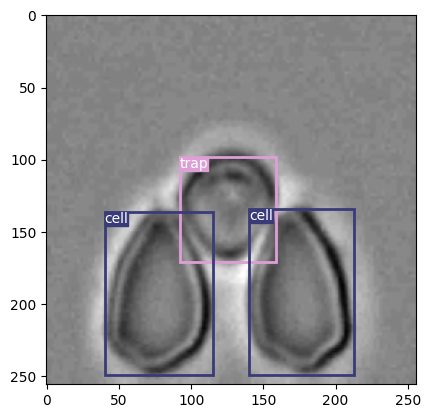

In [13]:
rescaled_anchors = torch.tensor(ANCHORS) / IMAGE_SIZE * GRID_SIZE

# Преобразуем клетки к рамкам
boxes = cells_to_bboxes(y.unsqueeze(0), rescaled_anchors)

# Оставим только рамки с объектами и нарисуем
boxes = boxes[boxes[:, 1] == 1]
fig = plot_image(x[0].to("cpu"), boxes, ["cell", "trap"])
plt.show()

##### Считаем ошибку на клеточном представлении

Ошибка из YOLO-V1:

<img height="300px" src="https://pylessons.com/media/Tutorials/YOLO-tutorials/YOLOv3-TF2-mnist/loss_function.png">

Наша ошибка немного отличается от той, что используется в YOLO:

In [14]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, pred: Tensor, target: Tensor, anchors: Tensor) -> Tensor:
        # ниже входные тензоры будут меняться на месте, так что склонируем их
        pred = pred.clone()
        target = target.clone()

        # разделяем рамки на содержащие объекты и не содержащие
        # NB: ещё могут быть -1, куда отнеслось более 1 объекта - их не учитываем
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # преобразуем предсказания bbox
        scores, pred_boxes, logits = process_yolo_preds(pred, anchors)

        # no object loss: кросс-энтропия вместо MSE
        no_object_loss = self.bce(
            (scores[no_obj]),
            (target[..., 0:1][no_obj]),
        )

        # object loss: учим предсказывать IoU
        ious = intersection_over_union(pred_boxes[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(scores[obj].sigmoid(), ious * target[..., 0:1][obj])

        # box coordinate loss: логарифмируем размеры рамок перед расчётом MSE
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        pred[..., 1:3] = pred[..., 1:3].sigmoid()
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors)
        box_loss = self.mse(pred[..., 1:5][obj], target[..., 1:5][obj])

        # class loss: здесь всё обычно
        class_loss = self.cross_entropy(logits[obj], target[..., 5][obj].long() - 1)

        # Total loss
        return box_loss + object_loss + no_object_loss + class_loss

In [15]:
torch.manual_seed(42)
x, y = next(iter(train_loader))
model = TinyYOLO(in_channels=1, num_classes=2, num_anchors=len(rescaled_anchors))
print(sum(p.numel() for p in model.parameters()))

preds = model.forward(x)

109431


In [16]:
loss_fn = YOLOLoss()
loss_fn.forward(preds, y, rescaled_anchors)

tensor(1.6536, grad_fn=<AddBackward0>)

#### 4. Пробуем обучить на одном батче

In [17]:
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [18]:
for _ in range(20):
    preds = model.forward(x)
    loss = loss_fn(preds, y, rescaled_anchors)
    print(loss)
    loss.backward()
    optim.step()
    optim.zero_grad()

tensor(1.6536, grad_fn=<AddBackward0>)
tensor(1.0844, grad_fn=<AddBackward0>)
tensor(0.7468, grad_fn=<AddBackward0>)
tensor(0.6020, grad_fn=<AddBackward0>)
tensor(0.5097, grad_fn=<AddBackward0>)
tensor(0.4231, grad_fn=<AddBackward0>)
tensor(0.3582, grad_fn=<AddBackward0>)
tensor(0.3415, grad_fn=<AddBackward0>)
tensor(0.2963, grad_fn=<AddBackward0>)
tensor(0.2654, grad_fn=<AddBackward0>)
tensor(0.2551, grad_fn=<AddBackward0>)
tensor(0.2219, grad_fn=<AddBackward0>)
tensor(0.2041, grad_fn=<AddBackward0>)
tensor(0.1994, grad_fn=<AddBackward0>)
tensor(0.1855, grad_fn=<AddBackward0>)
tensor(0.1680, grad_fn=<AddBackward0>)
tensor(0.1635, grad_fn=<AddBackward0>)
tensor(0.1508, grad_fn=<AddBackward0>)
tensor(0.1339, grad_fn=<AddBackward0>)
tensor(0.1294, grad_fn=<AddBackward0>)


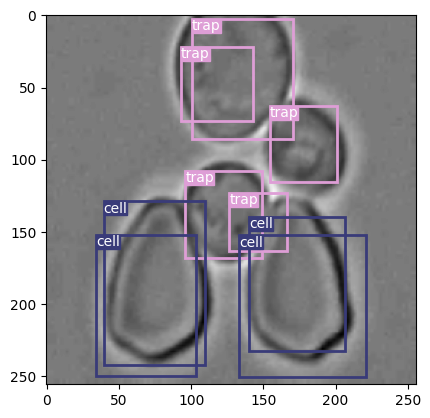

In [19]:
idx = 2
boxes = cells_to_bboxes(preds[idx].detach().unsqueeze(0), rescaled_anchors, is_predictions=True)
boxes = boxes[boxes[:, 1] > 0.2]
fig = plot_image(x[idx, 0].to("cpu"), boxes, ["cell", "trap"])
plt.show()

Много лишних рамок, как их убрать?

##### Non-max suppression

1. Сортируем гипотезы по убыванию оценки (confidence score)
2. Для каждой гипотезы в отсортированном списке:
    - добавляем в результирующий список
    - убираем из отсортированного списка все гипотезы, для которых
        *intersection over union (IoU)* выше заданного порога

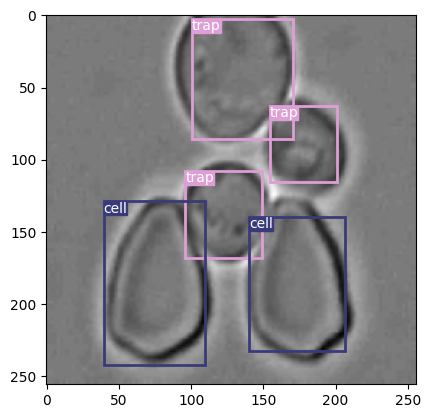

In [20]:
from torchvision.ops.boxes import nms

boxes = boxes[nms(box_convert(boxes[:, 2:], "cxcywh", "xyxy"), boxes[:, 1], iou_threshold=0.2)]
fig = plot_image(x[idx, 0].to("cpu"), boxes, ["cell", "trap"])
plt.show()

#### 5. Mean Average Precision

$mAP = \frac{1}{N} \sum_i \text{AP}_i$

$AP_i$ - average precision для класса $i$ (площадь под precision-recall кривой), $N$ - число классов

$
\text{Precision} = \frac{\text{True positive}}{\text{Predicted positive}}
\quad
\text{Recall} = \frac{\text{True positive}}{\text{Total positive}}
$

<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-birds-prediction-types.jpg" style="background:white" width="800"/>


Схема расчёта average precision подробнее:

1. Выбирается отсечка $t$, если у предсказанной и верной рамки $IoU > t$, то это True Positive. Ложные детекции помечаем как False Positive.


<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-confidence-scores.png" style="background:white" width="800"/>


2. Ранжируем по убыванию confidence score, считаем precision и recall накопленным итогом (для recall нужны False Negative - это необнаруженные объекты)
3. Оцениваем среднее значение precision по интерполированным значениям precision-recall кривой

<img src="../attachments/mapcalc-noloop.gif" style="background:white" width="800"/>



Посчитаем для одного батча

In [21]:
from pprint import pprint
from torchmetrics.detection import MeanAveragePrecision

metric = MeanAveragePrecision(iou_type="bbox", box_format="cxcywh", class_metrics=True)
predicted_boxes = []
target_boxes = []
# итерируемся по элементам батча, собирая пердсказанные и верные рамки
for i in range(len(y)):
    # получаем предсказанные рамки
    pred_boxes = cells_to_bboxes(preds[i:i+1], rescaled_anchors, is_predictions=True)
    # ВАЖНО: делаем non-max suppression ДО расчёта метрик
    pred_boxes = pred_boxes[nms(box_convert(pred_boxes[:, 2:], "cxcywh", "xyxy"), pred_boxes[:, 1], iou_threshold=0.3)]
    predicted_boxes.append(
        dict(
            boxes=pred_boxes[:, 2:],
            scores=pred_boxes[:, 1],
            labels=pred_boxes[:, 0].long(),
        )
    )
    # достаём правильные рамки
    true_boxes = cells_to_bboxes(y[i:i+1], rescaled_anchors)
    true_boxes = true_boxes[true_boxes[:, 1] == 1]

    target_boxes.append(
        dict(
            boxes=true_boxes[:, 2:],
            labels=true_boxes[:, 0].long(),
        )
    )

# обновляем состояние метрики
# можно было и сразу посчитать, но мы имитируем ситуацию,
# когда метрики используется для сбора данных по всем батчам
metric.update(predicted_boxes, target_boxes)

pprint(metric.compute())

{'classes': tensor([1, 2], dtype=torch.int32),
 'map': tensor(0.5466),
 'map_50': tensor(0.9754),
 'map_75': tensor(0.5929),
 'map_large': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_per_class': tensor([0.6091, 0.4840]),
 'map_small': tensor(0.5466),
 'mar_1': tensor(0.2940),
 'mar_10': tensor(0.6101),
 'mar_100': tensor(0.6101),
 'mar_100_per_class': tensor([0.6734, 0.5467]),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(0.6101)}
